In [1]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import t as student
from scipy.integrate import quad
from numpy.linalg import eigvals
from scipy.spatial import ConvexHull
from joblib import Parallel, delayed
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D


# Moment conditions for $p$ = 1

## DAR(1)

In [49]:
def plot_stationarity_DAR(nu):
    T = 30000  # samples
    step = 1000  # grid resolution
    tolerance = 0.01  # tolerance

    eta = student.rvs(df=nu, size=T) * np.sqrt((nu - 2) / nu)  # eta ~ student-t(0,1)
    rho_range = np.linspace(-1.5, 1.5, step)
    alpha_range = np.linspace(0.01, 10, step)

    def process_alpha(alpha):
        return (
            [[rho, alpha] for rho in rho_range if np.isclose(np.mean(np.log(np.abs(rho + np.sqrt(alpha) * eta))), 0, atol=tolerance)],
            [[rho, alpha] for rho in rho_range if np.isclose(np.mean(np.abs(rho + np.sqrt(alpha) * eta)), 1, atol=tolerance)],
        )

    # Explicit parallelization optimization
    results = Parallel(
        n_jobs=-1,  # Use all available cores
        backend='loky',  # Loky is the most robust backend
        batch_size='auto'  # Adjusts workload size dynamically
    )(delayed(process_alpha)(alpha) for alpha in alpha_range)

    frac_moment_points = [point for frac_result, _ in results for point in frac_result]
    first_moment_points = [point for _, first_result in results for point in first_result]

    second_moment_points = [[rho, 1 - rho**2] for rho in rho_range if rho**2 < 1]

    frac_moment = np.array(frac_moment_points)
    first_moment = np.array(first_moment_points)
    second_moment = np.array(second_moment_points)

    plt.figure(figsize=(10, 8))

    hull_frac = ConvexHull(frac_moment)
    for idx, i in enumerate(hull_frac.simplices):
        plt.plot(frac_moment[i, 0], frac_moment[i, 1], color='skyblue', linewidth=1.5,
                 label=r'$\frac{1}{T}\sum\log(|\rho_{1} +\sqrt{\alpha_{1}}\eta_{t}|) < 0$' if idx == 0 else "")

    hull_first = ConvexHull(first_moment)
    for idx, i in enumerate(hull_first.simplices):
        plt.plot(first_moment[i, 0], first_moment[i, 1], color='royalblue', linewidth=1.5,
                 label=r'$\frac{1}{T}\sum(|\rho_{1} +\sqrt{\alpha_{1}}\eta_{t}|) < 1$' if idx == 0 else "")

    hull_first = ConvexHull(second_moment)
    for idx, i in enumerate(hull_first.simplices):
        plt.plot(second_moment[i, 0], second_moment[i, 1], color='navy', linewidth=1.5,
                 label=r'$\rho_{1}^2 + \alpha_{1} < 1$' if idx == 0 else "")

    #plt.title(rf"Stationarity regions with $\eta_t \sim \text{{i.i.d. }} t_\nu(0,1)$ for $\nu$ = {nu}")
    plt.xlabel(r'$\rho_{1}$', fontsize=14)
    plt.ylabel(r'$\alpha_{1}$', fontsize=14)
    plt.legend(fontsize=9, loc='upper left')
    plt.grid(alpha=0.6)
    plt.ylim(0, 8)
    plt.xlim(-3, 3)
    plt.show()


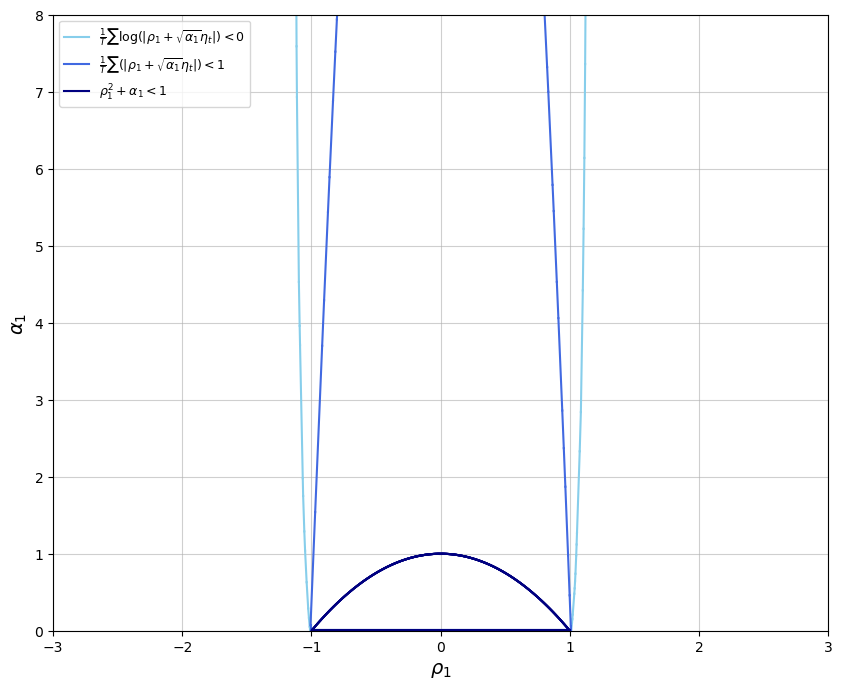

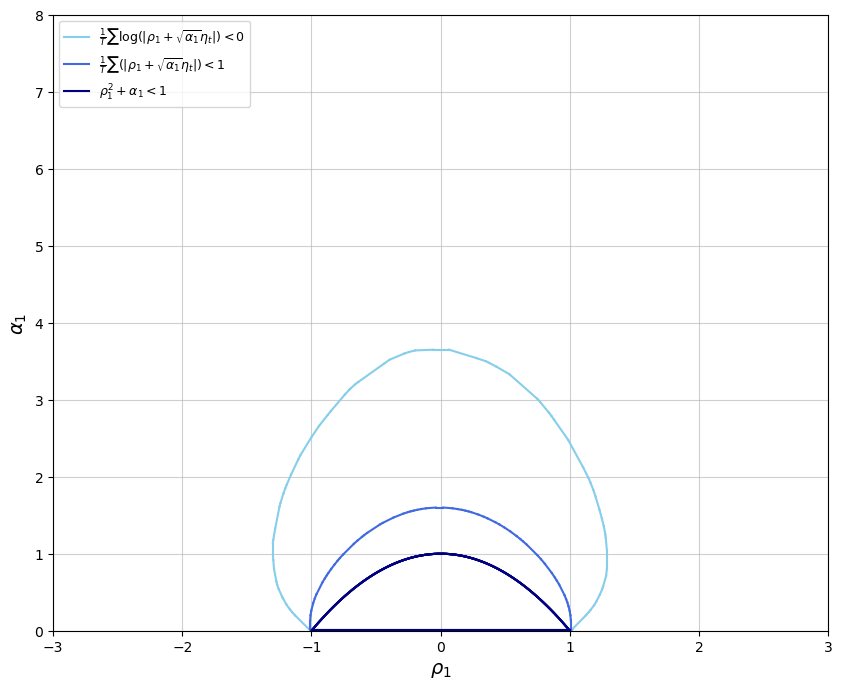

In [50]:
plot_stationarity_DAR(nu = 2.05)
plot_stationarity_DAR(nu = 1000)

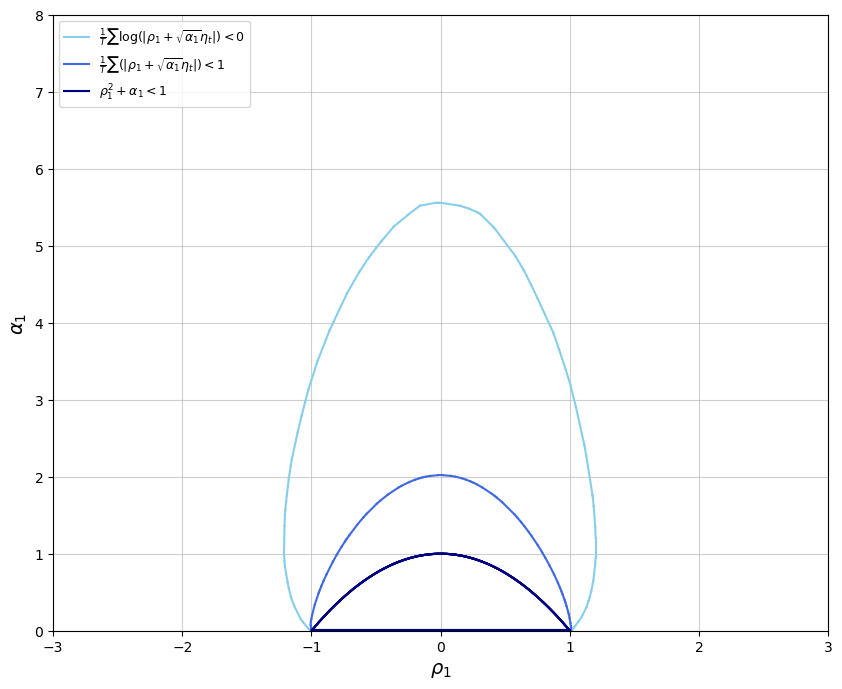

In [51]:
plot_stationarity_DAR(nu = 4)

In [52]:
import numpy as np
from scipy.stats import t as student
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

def plot_stationarity_DARMA(nu):


    # Parameters
    T = 30000  # samples
    step = 100  # grid resolution
    tolerance = 0.005  # tolerance

    # Generate eta and define ranges
    eta = student.rvs(df=nu, size=T) * np.sqrt((nu - 2) / nu)  # eta ~ student-t(0,1)
    rho_range = np.linspace(-1.5, 1.5, step)
    alpha_range = np.linspace(0.01, 10, step)
    phi_range = np.linspace(-1 + 1e-3, 1 - 1e-3, step)

    # Combined computation for fractional, first, and second moments
    def compute_moments(alpha, phi):
        scaling = 1 / np.sqrt(1 - phi**2)
        rho_values = rho_range[:, None]  # Shape: (len(rho_range), 1), for broadcasting

        # Compute rho + sqrt(alpha) * scaling * eta
        transformed_values = rho_values + np.sqrt(alpha) * scaling * eta

        # Compute moments
        frac_moment = np.mean(np.log(np.abs(transformed_values)), axis=1)
        first_moment = np.mean(np.abs(transformed_values), axis=1)

        # Filter results for fractional and first moments
        frac_results = rho_range[np.isclose(frac_moment, 0, atol=tolerance)]
        first_results = rho_range[np.isclose(first_moment, 1, atol=tolerance)]

        # Return results as lists
        frac_moment_points = [[rho, alpha, phi] for rho in frac_results]
        first_moment_points = [[rho, alpha, phi] for rho in first_results]

        return frac_moment_points, first_moment_points

    # Compute second moment analytically
    def compute_second_moment(alpha, phi):
        denominator = 1 - phi**2
        if denominator <= 0:  # Skip invalid cases where 1 - phi^2 <= 0
            return []
        
        # Compute rho^2 and ensure it's non-negative
        rho_squared = 1 - alpha / denominator
        if rho_squared < 0:
            return []  # No valid rho for this combination of alpha and phi

        # Include both positive and negative rho
        rho_values = [np.sqrt(rho_squared), -np.sqrt(rho_squared)]
        return [[rho, alpha, phi] for rho in rho_values]

    # Parallelized computation over alpha and phi for fractional and first moments
    results = Parallel(
        n_jobs=-1, backend='loky', batch_size='auto'
    )(
        delayed(compute_moments)(alpha, phi) for alpha in alpha_range for phi in phi_range
    )

    # Combine results
    frac_moment_points = [point for sublist in results for point in sublist[0]]
    first_moment_points = [point for sublist in results for point in sublist[1]]

    # Compute second moment points
    second_moment_results = Parallel(
        n_jobs=-1, backend='loky', batch_size='auto'
    )(
        delayed(compute_second_moment)(alpha, phi) for alpha in alpha_range for phi in phi_range
    )

    # Combine second moment results
    second_moment_points = [point for sublist in second_moment_results for point in sublist]

    # Convert to numpy arrays
    frac_moment = np.array(frac_moment_points)
    first_moment = np.array(first_moment_points)
    second_moment = np.array(second_moment_points)

    # Define function to process data for each moment
    def process_moment_data(rho, phi, alpha, grid_points=2000, sigma=5):
        rho_grid, phi_grid = np.meshgrid(
            np.linspace(rho.min(), rho.max(), grid_points),
            np.linspace(phi.min(), phi.max(), grid_points)
        )
        alpha_grid = griddata((rho, phi), alpha, (rho_grid, phi_grid), method='cubic')
        alpha_grid = gaussian_filter(alpha_grid, sigma=sigma)
        return rho_grid, phi_grid, alpha_grid

    # Process data for all moments
    rho_grid_frac, phi_grid_frac, alpha_grid_frac = process_moment_data(
        frac_moment[:, 0], frac_moment[:, 2], frac_moment[:, 1]
    )
    rho_grid_first, phi_grid_first, alpha_grid_first = process_moment_data(
        first_moment[:, 0], first_moment[:, 2], first_moment[:, 1]
    )
    rho_grid_second, phi_grid_second, alpha_grid_second = process_moment_data(
        second_moment[:, 0], second_moment[:, 2], second_moment[:, 1]
    )

    # Define consistent axis limits
    rho_min = min(rho_grid_frac.min(), rho_grid_first.min(), rho_grid_second.min())
    rho_max = max(rho_grid_frac.max(), rho_grid_first.max(), rho_grid_second.max())
    phi_min = min(phi_grid_frac.min(), phi_grid_first.min(), phi_grid_second.min())
    phi_max = max(phi_grid_frac.max(), phi_grid_first.max(), phi_grid_second.max())

    # Handle NaN/Inf in alpha grids
    alpha_min = np.nanmin([np.nanmin(alpha_grid_frac), np.nanmin(alpha_grid_first), np.nanmin(alpha_grid_second)])
    alpha_max = np.nanmax([np.nanmax(alpha_grid_frac), np.nanmax(alpha_grid_first), np.nanmax(alpha_grid_second)])

    # Ensure alpha limits are finite
    if not np.isfinite(alpha_min) or not np.isfinite(alpha_max):
        alpha_min, alpha_max = 0, 1  # Default fallback for alpha limits

    rho_lim = (rho_min, rho_max)
    phi_lim = (phi_min, phi_max)
    alpha_lim = (alpha_min, alpha_max)

    # Create subplots for all moments
    fig = plt.figure(figsize=(24, 8))

    def plot_surface(ax, rho_grid, phi_grid, alpha_grid, title, cmap='PuBu'):
        surf = ax.plot_surface(
            rho_grid, phi_grid, alpha_grid,
            cmap=cmap, edgecolor='none', alpha=0.9
        )
        ax.set_xlim(rho_lim)
        ax.set_ylim(phi_lim)
        ax.set_zlim(alpha_lim)
        ax.set_xlabel(r'$\rho$')
        ax.set_ylabel(r'$\phi$')
        ax.set_zlabel(r'$\alpha$')
        ax.set_title(title)
        return surf

    elev_val = 20
    azim_val = 60

    # Plot each moment
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = plot_surface(ax1, rho_grid_frac, phi_grid_frac, alpha_grid_frac, r'$\frac{1}{T}\sum\log(|\rho_{1} +\sqrt{\alpha_{1}} \frac{1}{\sqrt{1-\phi^{2}}} \eta_{t}|) < 0$')
    ax1.view_init(elev=elev_val, azim=azim_val)
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = plot_surface(ax2, rho_grid_first, phi_grid_first, alpha_grid_first, r'$\frac{1}{T}\sum(|\rho_{1} +\sqrt{\alpha_{1}} \frac{1}{\sqrt{1-\phi^{2}}} \eta_{t}|) < 1$')
    ax2.view_init(elev=elev_val, azim=azim_val)
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = plot_surface(ax3, rho_grid_second, phi_grid_second, alpha_grid_second, r'$\rho_{1}^2 + \alpha_{1} \frac{1} {1-\phi^{2}}< 1$')
    ax3.view_init(elev=elev_val, azim=azim_val)
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

    # Show
    #fig.suptitle(rf"Stationarity regions with $\eta_t \sim \text{{i.i.d. }} t_\nu(0,1)$ for $\nu$ = {nu}", fontsize=16, y=1)
    plt.tight_layout()
    plt.show()


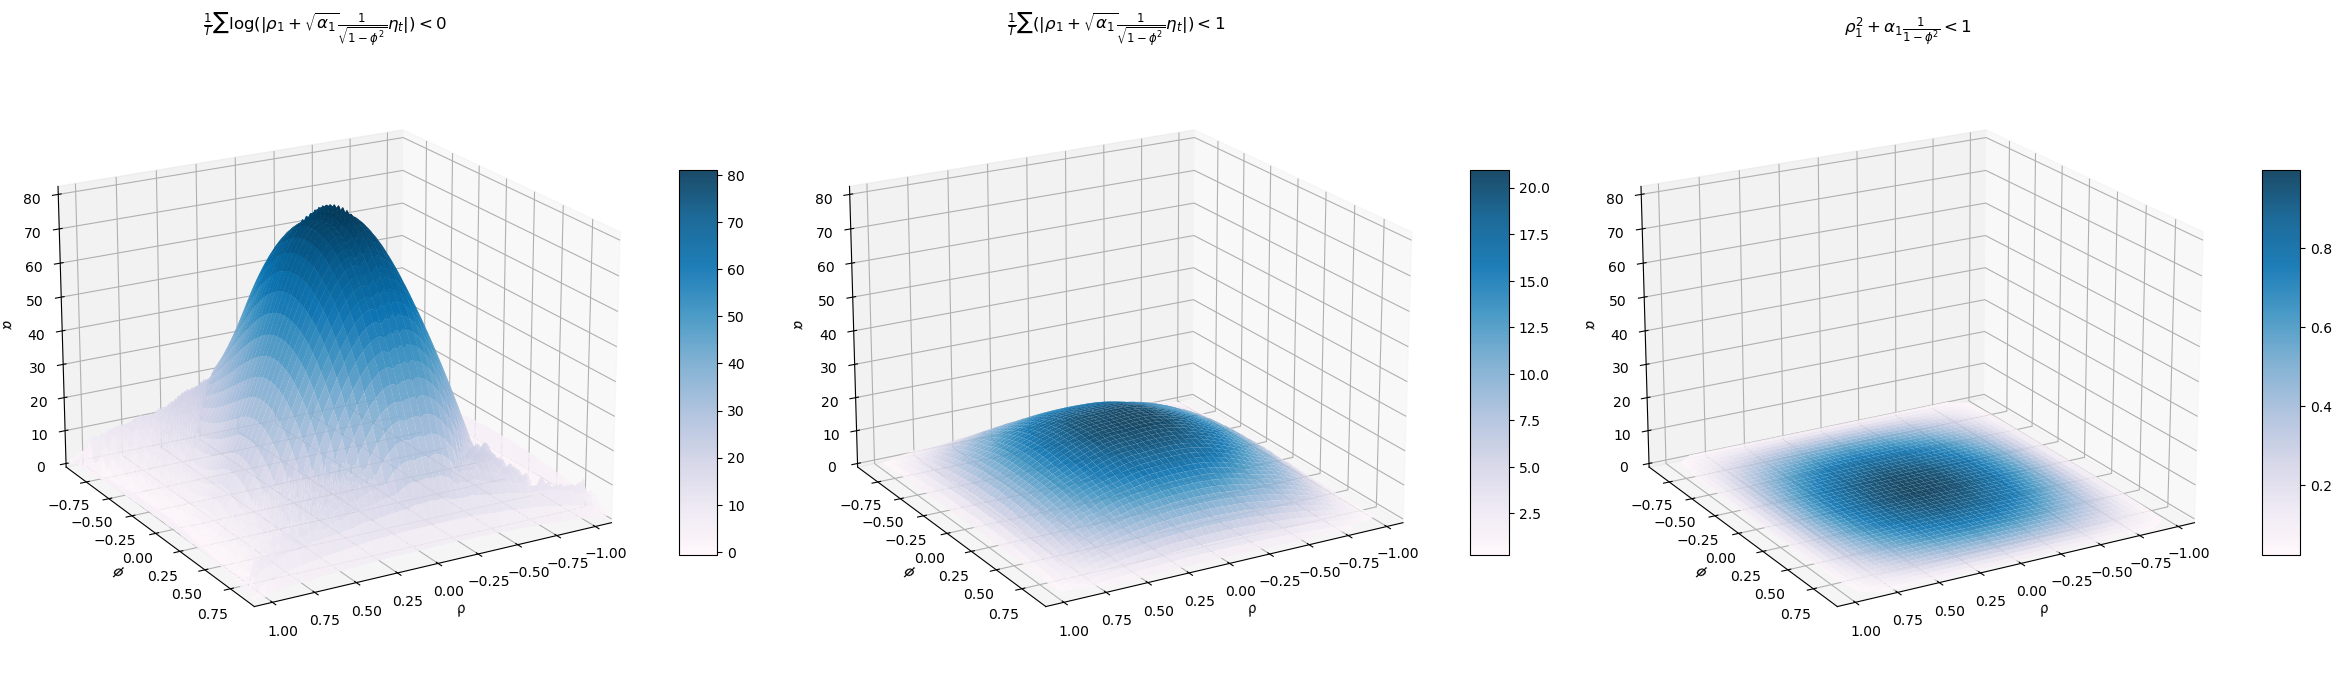

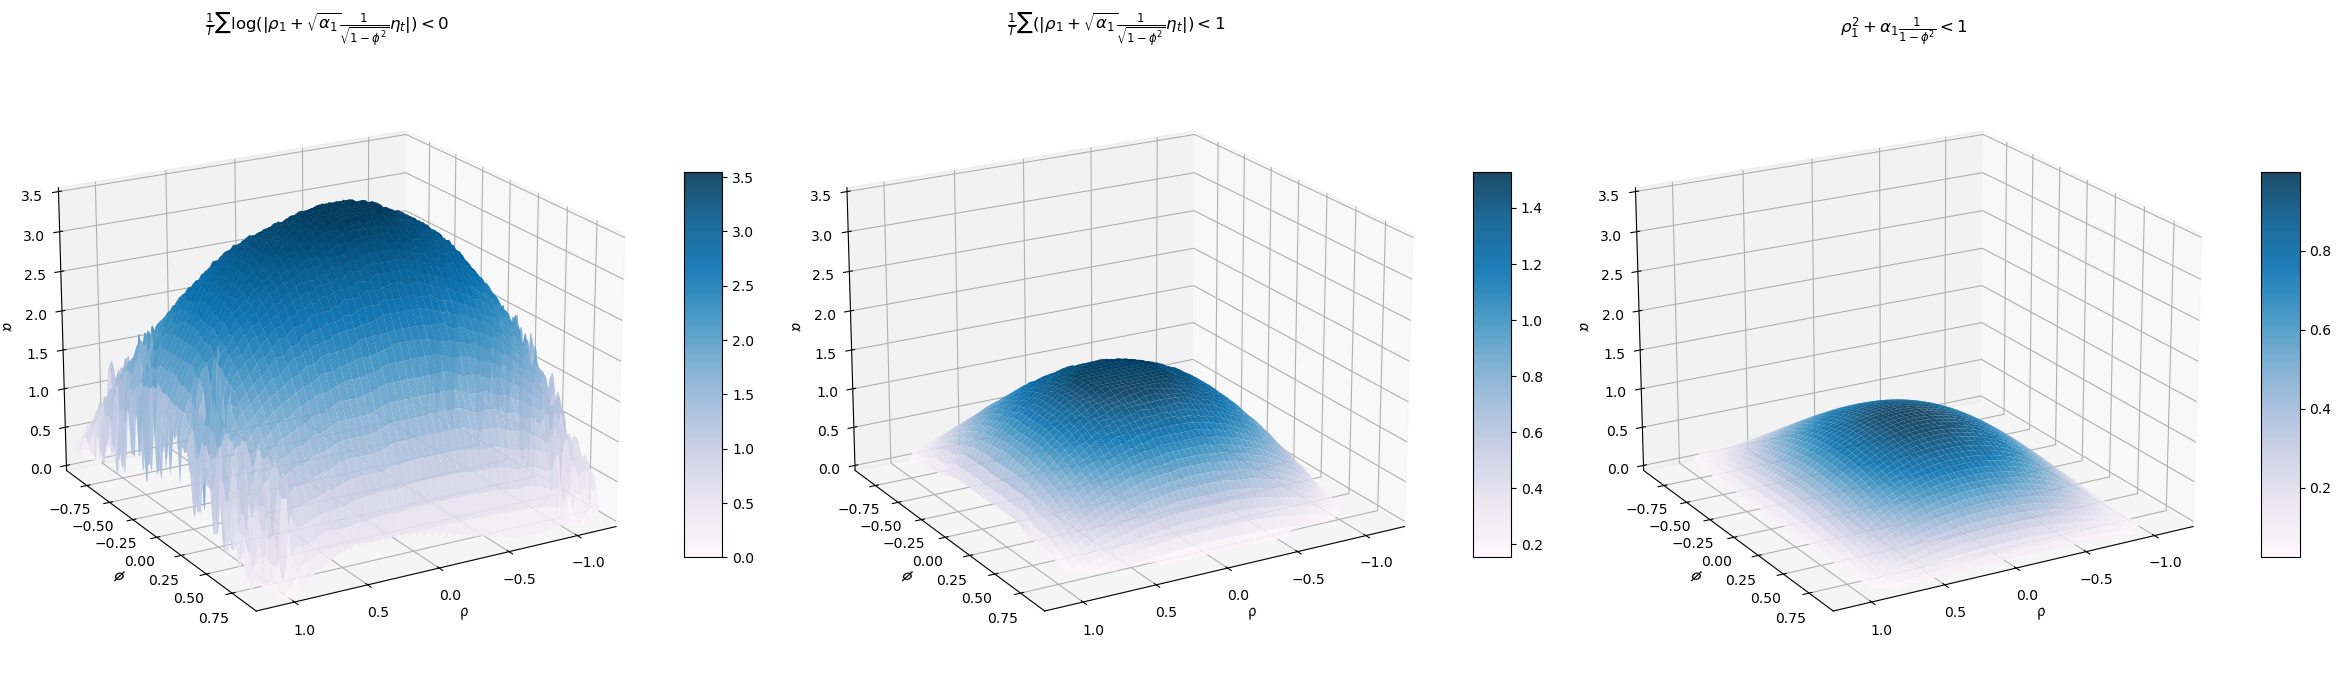

In [53]:
plot_stationarity_DARMA(nu = 2.05)
plot_stationarity_DARMA(nu = 1000)